In [366]:
## Written by: Hongtao Hao
## Attribution: Hugh Liu's solutions for CS540 2021 Epic 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def entropy(data):
    entropy = 0
    count = len(data)
    n0 = np.sum(data[:, -1] == 0)
    n1 = np.sum(data[:, -1] == 1)
    if n0 == 0 or n1 == 0: 
        return 0
    else: 
        for n in [n0, n1]:
            p = n/count
            entropy += - (p * np.log2(p))
        return entropy

def entropy_split(data, threshold, feature):
    entropy = 0
    count = len(data) # total number of instances
    n0 = np.sum(data[:, int(feature)-1] >= threshold)
    n1 = np.sum(data[:, int(feature)-1] < threshold)
    if n0 == 0 or n1 == 0: 
        return 0
    else: 
        for n in [n0, n1]:
            p = n/count
            entropy += - (p * np.log2(p))
        return entropy

def infogain(data, feature, threshold):
    count = len(data)
    #print(threshold)
    #print(feature)
    #print(data)
    d1 = data[data[:, feature - 1] >= threshold]
    d2 = data[data[:, feature - 1] < threshold]
    proportion_d1 = len(d1) / count
    proportion_d2 = len(d2) / count
    info_gain = entropy(data) - proportion_d1 * entropy(d1) - proportion_d2 * entropy(d2)
    entropy_s = entropy_split(data, threshold, feature)
    if entropy_s == 0:
        gain_ratio = np.nan
    else:
        gain_ratio = info_gain / entropy_s
    return feature, threshold, gain_ratio, entropy_s, info_gain

def get_best_split(data, feature_list):
    c = len(data)
    c0 = sum(b[-1] == 0 for b in data)
    #if c0 == c: return 0, None, None, None, None
    #if c0 == 0: return 1, None, None, None, None
    
    #ig = pd.DataFrame(columns = ['feature', 'threshold', 'gain_ratio', 'entropy', 'info_gain'])
    ig = [infogain(
        data, feature, threshold) for feature in feature_list for threshold in np.unique(data[:,feature-1])]
    #ig = [[infogain(
    #    data, feature, threshold) for threshold in np.unique(data[:,feature-1])] for feature in feature_list]
    #ig = np.array(ig)
    ig = np.array(ig)
    if np.nanmax(ig[:,3])==0:
        print("entropy of split is zero")
        if c0 > c - c0:
            print("entropy of split is zero and c0 > c-c0")
            return 0, None, None, None, None
        else:
            print("entropy of split is zero and c0 < c-c0")
            return 1, None, None, None, None
    
    max_ig = np.nanmax(ig[:,2])
    if max_ig == 0:
        print("max info gain is 0")
        if c0 > c - c0:
            print("max info gain is 0 and c0 > c-c0")
            return 0, None, None, None, None
        else:
            print("max info gain is 0 and c0 < c-c0")
            return 1, None, None, None, None
    #print(len(ig[ig[:,2]==max_ig][:,0]))
    #print(np.nanmax(ig[:,2]))
    #print(ig[ig[:,2]==max_ig][:,0])
    if len(ig[ig[:,2]==max_ig][:,0]) > 1:
        feature = int(ig[ig[:,2]==max_ig][:,0][len(ig[ig[:,2]==max_ig][:,0])-1])
        threshold = ig[ig[:,2]==max_ig][:,1][len(ig[ig[:,2]==max_ig][:,0])-1]
        print("got here")
    else:
        feature = int(ig[ig[:,2]==max_ig][:,0])
        threshold = ig[ig[:,2]==max_ig][:,1]
    dl = data[data[:, feature - 1] >= threshold]
    dl_n0 = np.sum(dl[:,-1] == 0)
    dl_n1 = np.sum(dl[:,-1] == 1)
    if dl_n0 >= dl_n1:
        dl_prediction = 0
    else:
        dl_prediction = 1
    dr = data[data[:, feature - 1] < threshold]
    dr_n0 = np.sum(dr[:,-1] == 0)
    dr_n1 = np.sum(dr[:,-1] == 1)
    if dr_n0 >= dl_n1:
        dr_prediction = 0
    else:
        dr_prediction = 1
    return feature, threshold, dl_prediction, dr_prediction, ig


class Node:
    def __init__(self, feature = None, threshold = None, l_prediction = None, r_prediction = None):
        self.feature = feature
        self.threshold = threshold
        self.l_prediction = l_prediction
        self.r_prediction = r_prediction
        self.l = None
        self.r = None
        self.correct = 0

def split(data, node):
    # split the data into two parts
    feature, threshold = node.feature, node.threshold
    d1 = data[data[:,feature-1] >= threshold]
    d2 = data[data[:,feature-1] < threshold]
    return (d1,d2)

def create_tree(data, node, feature_list):
    d1,d2 = split(data, node)
    f1, t1, l1_prediction, r1_prediction, ig = get_best_split(d1, feature_list)
    if t1 == None: 
        node.l_prediction = f1
        print("tl node empty")
    else:
        node.l = Node(f1, t1, l1_prediction, r1_prediction)
        create_tree(d1, node.l, feature_list)
    f2, t2, l2_prediction, r2_prediction, ig = get_best_split(d2, feature_list)
    if t2 == None: 
        node.r_prediction = f2
        print("tr node empty+")
    else:
        node.r = Node(f2, t2, l2_prediction, r2_prediction)
        create_tree(d2, node.r, feature_list)  

def expand_root(data, feature_list):
    feature, threshold, dl, dr, ig = get_best_split(
        data, feature_list)
    root = Node(feature, threshold)
    print(pd.DataFrame(ig, columns = ['feature', 'threshold', 'gain_ratio', 'entropy', 'info_gain']).to_latex(index=False))
    create_tree(data, root, feature_list)
    return root

#function to help draw decision boundary
#function courtesty of piazza post @78

def draw_decision_boundary(model_function,node,grid_min=-1.5, grid_max=1.5,savefile=None):
    colors=['#91678f','#afd6d2'] # hex color for [y=0, y=1]
    xval = np.linspace(grid_min,grid_max,50).tolist() # grid generation
    xdata = []
    for i in range(len(xval)):
        for j in range(len(xval)):
            xdata.append([xval[i],xval[j]])

    df = pd.DataFrame(data=xdata,columns=['x_1','x_2']) # creates a dataframe to standardize labels
    df['y'] = df.apply(model_function,axis=1, args = [node]) # applies model from model_function arg
    d_columns = df.columns.to_list() # grabs column headers
    y_label = d_columns[-1] # uses last header as label
    d_xfeature = d_columns[0] # uses first header as x_1 feature
    d_yfeature = d_columns[1] # uses second header as x_1 feature
    df = df.sort_values(by=y_label) # sorts by label to ensure correct ordering in plotting loop

    d_xlabel = f"feature  $\mathit{{{d_xfeature}}}$" # label for x-axis
    dy_ylabel = f"feature  $\mathit{{{d_yfeature}}}$" # label for y-axis
    plt.xlabel(d_xlabel, fontsize=10) # set x-axis label
    plt.ylabel(dy_ylabel, fontsize=10) # set y-axis label
    legend_labels = [] # create container for legend labels to ensure correct ordering

    for i,label in enumerate(df[y_label].unique().tolist()): # loop through placeholder dataframe
        df_set = df[df[y_label]==label] # sort according to label
        set_x = df_set[d_xfeature] # grab x_1 feature set
        set_y = df_set[d_yfeature] # grab x_2 feature set
        plt.scatter(set_x,set_y,c=colors[i],marker='s', s=40) # marker='s' for square, s=40 for size of squares large enough
        legend_labels.append(f"""{y_label} = {label}""") # apply labels for legend in the same order as sorted dataframe

    plt.title("Model Decision Boundary", fontsize=12) # set plot title
    ax = plt.gca() # grab to set background color of plot
    ax.set_facecolor('#2b2d2e') # set aforementioned background color in hex color
    plt.legend(legend_labels) # create legend with sorted labels

    if savefile is not None: # save your plot as .png file
        plt.savefig(savefile)
    plt.show() # show plot with decision bounds

def print_tree(node, f, prefix=''):
    feature = node.feature
    threshold = node.threshold
    l_prediction = node.l_prediction
    r_prediction = node.r_prediction
    l = node.l
    r = node.r
    if l == None:
        #f.write(prefix+'if (x'+str(feature)+') <= '+str(threshold)+') return '+str(l_prediction)+'\n')
        print(prefix+'if (x'+str(feature)+') >= '+str(threshold)+') return '+str(l_prediction)+'\n')
    else:
        #f.write(prefix+'if (x'+str(feature)+') <= '+str(threshold)+')\n')
        print(prefix+'if (x'+str(feature)+') >= '+str(threshold)+')\n')
        print_tree(l, f, prefix+' ')
    if r == None:
        print(prefix+'else return '+str(r_prediction)+'\n')
        #f.write(prefix+'else return '+str(r_prediction)+'\n')
    else:
        #f.write(prefix+'else\n')
        print(prefix+'else\n')
        print_tree(r, f, prefix+' ')

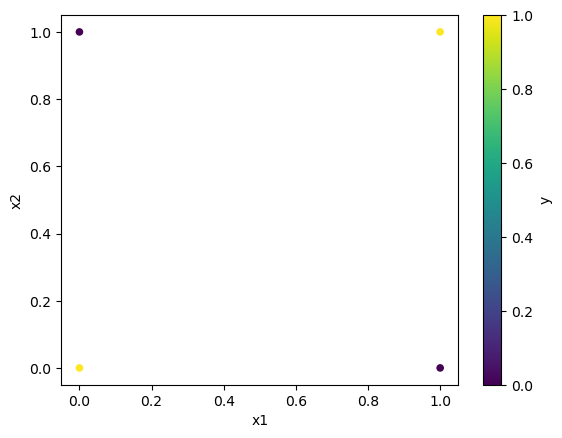

In [410]:
#Question 2.2
dict_x = {'x1': [1, 0, 0, 1], 'x2': [1, 1, 0, 0], 'y': [1, 0, 1, 0]}
dt = pd.DataFrame(dict_x)
dt.plot.scatter(x='x1', y = 'x2', c = 'y', cmap = 'viridis')
plt.savefig('./HW/HW2_toy_example.png')

In [352]:
#Question 2.3
Druns = np.loadtxt('./HW/Homework 2 data/Druns.txt')

feature_list = [1, 2]
expand_root(Druns, feature_list)
#np.unique(D1[:,0])



\begin{tabular}{rrrrr}
\toprule
 feature &  threshold &  gain\_ratio &  entropy &  info\_gain \\
\midrule
     1.0 &        0.0 &         NaN & 0.000000 &   0.000000 \\
     1.0 &        0.1 &    0.100518 & 0.439497 &   0.044177 \\
     2.0 &       -2.0 &         NaN & 0.000000 &   0.000000 \\
     2.0 &       -1.0 &    0.100518 & 0.439497 &   0.044177 \\
     2.0 &        0.0 &    0.055954 & 0.684038 &   0.038275 \\
     2.0 &        1.0 &    0.005780 & 0.845351 &   0.004886 \\
     2.0 &        2.0 &    0.001144 & 0.945660 &   0.001082 \\
     2.0 &        3.0 &    0.016411 & 0.994030 &   0.016313 \\
     2.0 &        4.0 &    0.049749 & 0.994030 &   0.049452 \\
     2.0 &        5.0 &    0.111240 & 0.945660 &   0.105196 \\
     2.0 &        6.0 &    0.236100 & 0.845351 &   0.199587 \\
     2.0 &        7.0 &    0.055954 & 0.684038 &   0.038275 \\
     2.0 &        8.0 &    0.430157 & 0.439497 &   0.189053 \\
\bottomrule
\end{tabular}

entropy of split is zero
entropy of split is zer

/var/folders/b2/8cn96b9x6qz0b7b79dn_n_1h0000gn/T/ipykernel_42279/3886758716.py:147: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(ig, columns = ['feature', 'threshold', 'gain_ratio', 'entropy', 'info_gain']).to_latex(index=False))


In [353]:
#2.4 Print out decision tree rules
#load D3leaves.txt
D3leaves = np.loadtxt('./HW/Homework 2 data/D3leaves.txt')

feature_list = [1, 2]
root1 = expand_root(D3leaves, feature_list)
print_tree(root1, g, '')

got here
\begin{tabular}{rrrrr}
\toprule
 feature &  threshold &  gain\_ratio &  entropy &  info\_gain \\
\midrule
     1.0 &        1.0 &         NaN & 0.000000 &   0.000000 \\
     1.0 &       10.0 &    0.331560 & 0.970951 &   0.321928 \\
     2.0 &        1.0 &         NaN & 0.000000 &   0.000000 \\
     2.0 &        2.0 &    0.331560 & 0.970951 &   0.321928 \\
     2.0 &        3.0 &    0.176065 & 0.970951 &   0.170951 \\
\bottomrule
\end{tabular}

max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
entropy of split is zero
entropy of split is zero and c0 < c-c0
tl node empty
entropy of split is zero
entropy of split is zero and c0 > c-c0
tr node empty+
if (x2) >= 2.0) return 1

else

 if (x1) >= [10.]) return 1

 else return 0



/var/folders/b2/8cn96b9x6qz0b7b79dn_n_1h0000gn/T/ipykernel_42279/3886758716.py:147: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(ig, columns = ['feature', 'threshold', 'gain_ratio', 'entropy', 'info_gain']).to_latex(index=False))


In [354]:
#2.5 Interpretability
D1 = np.loadtxt('./HW/Homework 2 data/D1.txt')

feature_list = [1, 2]
rootD1 = expand_root(D1, feature_list)
print_tree(rootD1, g, '')

/var/folders/b2/8cn96b9x6qz0b7b79dn_n_1h0000gn/T/ipykernel_42279/3886758716.py:147: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(ig, columns = ['feature', 'threshold', 'gain_ratio', 'entropy', 'info_gain']).to_latex(index=False))


\begin{tabular}{rrrrr}
\toprule
 feature &  threshold &   gain\_ratio &  entropy &    info\_gain \\
\midrule
     1.0 &   0.001191 &          NaN & 0.000000 & 0.000000e+00 \\
     1.0 &   0.001405 & 2.434195e-02 & 0.011408 & 2.776871e-04 \\
     1.0 &   0.001824 & 2.669737e-02 & 0.020814 & 5.556809e-04 \\
     1.0 &   0.001943 & 2.830507e-02 & 0.029464 & 8.339821e-04 \\
     1.0 &   0.003089 & 2.957261e-02 & 0.037622 & 1.112591e-03 \\
     1.0 &   0.005812 & 3.064007e-02 & 0.045415 & 1.391509e-03 \\
     1.0 &   0.006173 & 3.157393e-02 & 0.052915 & 1.670737e-03 \\
     1.0 &   0.007471 & 3.241142e-02 & 0.060172 & 1.950274e-03 \\
     1.0 &   0.008663 & 3.317571e-02 & 0.067222 & 2.230123e-03 \\
     1.0 &   0.008861 & 3.388227e-02 & 0.074088 & 2.510283e-03 \\
     1.0 &   0.009175 & 3.454198e-02 & 0.080793 & 2.790755e-03 \\
     1.0 &   0.010672 & 3.516282e-02 & 0.087352 & 3.071540e-03 \\
     1.0 &   0.010790 & 3.575083e-02 & 0.093778 & 3.352639e-03 \\
     1.0 &   0.010938 & 3.631071e

In [357]:
D2 = np.loadtxt('./HW/Homework 2 data/D2.txt')

feature_list = [1, 2]
rootD2 = expand_root(D2, feature_list)
print_tree(rootD2, g, '')

/var/folders/b2/8cn96b9x6qz0b7b79dn_n_1h0000gn/T/ipykernel_42279/3886758716.py:147: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(ig, columns = ['feature', 'threshold', 'gain_ratio', 'entropy', 'info_gain']).to_latex(index=False))


\begin{tabular}{rrrrr}
\toprule
 feature &  threshold &  gain\_ratio &  entropy &  info\_gain \\
\midrule
     1.0 &   0.000997 &         NaN & 0.000000 &   0.000000 \\
     1.0 &   0.002848 &    0.085714 & 0.011408 &   0.000978 \\
     1.0 &   0.003742 &    0.094023 & 0.020814 &   0.001957 \\
     1.0 &   0.004763 &    0.099701 & 0.029464 &   0.002938 \\
     1.0 &   0.005820 &    0.104183 & 0.037622 &   0.003920 \\
     1.0 &   0.011835 &    0.107962 & 0.045415 &   0.004903 \\
     1.0 &   0.013345 &    0.111271 & 0.052915 &   0.005888 \\
     1.0 &   0.013377 &    0.114241 & 0.060172 &   0.006874 \\
     1.0 &   0.014763 &    0.116955 & 0.067222 &   0.007862 \\
     1.0 &   0.017627 &    0.119465 & 0.074088 &   0.008851 \\
     1.0 &   0.017791 &    0.121812 & 0.080793 &   0.009842 \\
     1.0 &   0.018578 &    0.124022 & 0.087352 &   0.010834 \\
     1.0 &   0.018630 &    0.126117 & 0.093778 &   0.011827 \\
     1.0 &   0.020892 &    0.128114 & 0.100082 &   0.012822 \\
     1.0 &  

got here
max info gain is 0
max info gain is 0 and c0 > c-c0
tl node empty
entropy of split is zero
entropy of split is zero and c0 < c-c0
tr node empty+
max info gain is 0
max info gain is 0 and c0 > c-c0
tr node empty+
max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
got here
max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
entropy of split is zero
entropy of split is zero and c0 > c-c0
tr node empty+
got here
entropy of split is zero
entropy of split is zero and c0 < c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 > c-c0
tr node empty+
max info gain is 0
max info gain is 0 and c0 > c-c0
tr node empty+
max info gain is 0
max info gain is 0 and c0 > c-c0
tr node empty+
if (x1) >= [0.533076])

 if (x2) >= [0.228007])

  if (x2) >= [0.424906]) return 1

  else

   if (x1) >= [0.708127]) return 1

   else

    if (x2) >= [0.32625])

     if (x1) >= [0.595471])

      if (x1) >= [0.646007]) return 1

      else

       if (x2) >= [0.403494

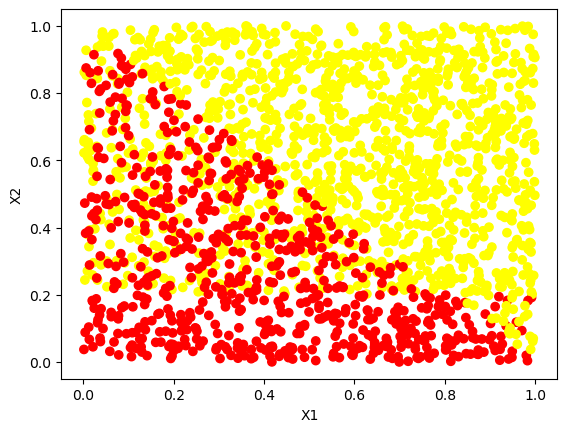

In [69]:
#2.6make scatterplot 
D1 = np.loadtxt('./HW/Homework 2 data/D1.txt')
D2 = np.loadtxt('./HW/Homework 2 data/D2.txt')
plt.scatter(x = D1[:,0], y = D1[:,1], c = D1[:,2], cmap = "autumn")
plt.xlabel("X1")
plt.ylabel("X2")
plt.savefig('./HW/HW2_q2.6_D1.png')

plt.scatter(x = D2[:,0], y = D2[:,1], c = D2[:,2], cmap = "autumn")
plt.xlabel("X1")
plt.ylabel("X2")
plt.savefig('./HW/HW2_q2.6_D2.png')

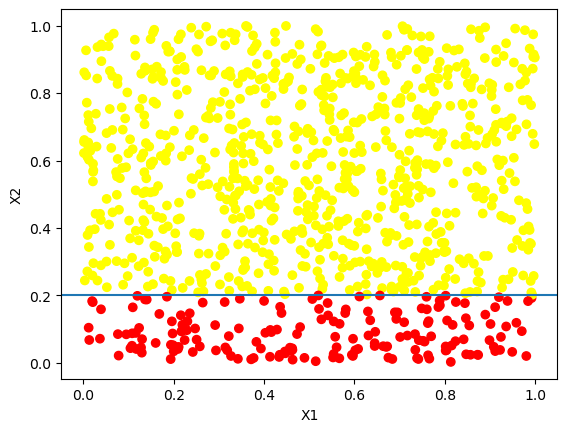

In [361]:
#visualize decision boundary for D1
plt.scatter(x = D1[:,0], y = D1[:,1], c = D1[:,2], cmap = "autumn")
plt.xlabel("X1")
plt.ylabel("X2")
plt.axhline(y = 0.201829)
plt.savefig('./HW/HW2_q2.6_D1_with_boundary.png')


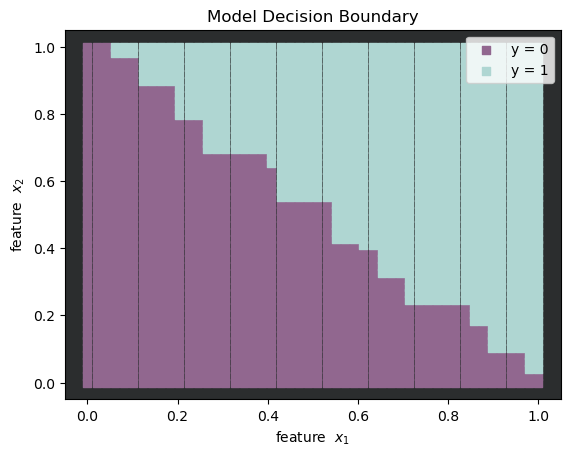

In [367]:
#visualize decision boundary for D2
draw_decision_boundary(tree_prediction,rootD2, grid_min=0, grid_max=1.0, savefile = './HW/HW2_decision_boundary_D2.png') # generate decision boundary plot


In [368]:
#2.7 - train decision tree model on datasets of different sizes

Dbig = np.loadtxt('./HW/Homework 2 data/Dbig.txt')
print(np.max(Dbig[:,1]), np.min(Dbig[:,1]))
Dbig = pd.DataFrame(Dbig)
Dbig_shuffle = Dbig.sample(frac = 1).reset_index(drop = True)
Dbig_train = Dbig_shuffle[:8192]
Dbig_test = pd.DataFrame.to_numpy(Dbig_shuffle[8193:])

#generate training sets 
D32 = pd.DataFrame.to_numpy(Dbig_train[0:32])
D128 = pd.DataFrame.to_numpy(Dbig_train[0:128])
D512 = pd.DataFrame.to_numpy(Dbig_train[0:512])
D2048 = pd.DataFrame.to_numpy(Dbig_train[0:2048])   
D8192 = pd.DataFrame.to_numpy(Dbig_train[0:8192])

rootD32 = expand_root(D32, feature_list)
rootD128 = expand_root(D128, feature_list)
rootD512 = expand_root(D512, feature_list)
rootD2048 = expand_root(D2048, feature_list)
rootD8192 = expand_root(D8192, feature_list)



1.499608 -1.499962
\begin{tabular}{rrrrr}
\toprule
 feature &  threshold &  gain\_ratio &  entropy &  info\_gain \\
\midrule
     1.0 &  -1.459474 &         NaN & 0.000000 &   0.000000 \\
     1.0 &  -1.449620 &    0.096545 & 0.200622 &   0.019369 \\
     1.0 &  -1.382700 &    0.117225 & 0.337290 &   0.039539 \\
     1.0 &  -1.382526 &    0.134961 & 0.448864 &   0.060579 \\
     1.0 &  -1.296574 &    0.151906 & 0.543564 &   0.082571 \\
     1.0 &  -1.286290 &    0.168898 & 0.625262 &   0.105605 \\
     1.0 &  -1.211877 &    0.186422 & 0.696212 &   0.129789 \\
     1.0 &  -1.077745 &    0.204844 & 0.757878 &   0.155247 \\
     1.0 &  -1.006834 &    0.224490 & 0.811278 &   0.182123 \\
     1.0 &  -0.999963 &    0.245690 & 0.857148 &   0.210592 \\
     1.0 &  -0.963884 &    0.268808 & 0.896038 &   0.240862 \\
     1.0 &  -0.948296 &    0.131531 & 0.928362 &   0.122109 \\
     1.0 &  -0.944879 &    0.155255 & 0.954434 &   0.148181 \\
     1.0 &  -0.828744 &    0.086379 & 0.974489 &   0.084

/var/folders/b2/8cn96b9x6qz0b7b79dn_n_1h0000gn/T/ipykernel_42279/1162437439.py:147: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(ig, columns = ['feature', 'threshold', 'gain_ratio', 'entropy', 'info_gain']).to_latex(index=False))
/var/folders/b2/8cn96b9x6qz0b7b79dn_n_1h0000gn/T/ipykernel_42279/1162437439.py:147: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(ig, columns = ['feature', 'threshold', 'gain_ratio', 'entropy', 'info_gain']).t

\begin{tabular}{rrrrr}
\toprule
 feature &  threshold &  gain\_ratio &  entropy &  info\_gain \\
\midrule
     1.0 &  -1.497724 &         NaN & 0.000000 &   0.000000 \\
     1.0 &  -1.496801 &    0.067202 & 0.020393 &   0.001370 \\
     1.0 &  -1.489532 &    0.074425 & 0.036875 &   0.002744 \\
     1.0 &  -1.486077 &    0.079454 & 0.051876 &   0.004122 \\
     1.0 &  -1.485947 &    0.083482 & 0.065914 &   0.005503 \\
     1.0 &  -1.484794 &    0.086919 & 0.079235 &   0.006887 \\
     1.0 &  -1.484234 &    0.089962 & 0.091983 &   0.008275 \\
     1.0 &  -1.482934 &    0.092721 & 0.104254 &   0.009666 \\
     1.0 &  -1.478875 &    0.095264 & 0.116115 &   0.011062 \\
     1.0 &  -1.464624 &    0.097637 & 0.127617 &   0.012460 \\
     1.0 &  -1.459474 &    0.099873 & 0.138800 &   0.013862 \\
     1.0 &  -1.457575 &    0.101996 & 0.149696 &   0.015268 \\
     1.0 &  -1.449620 &    0.104023 & 0.160329 &   0.016678 \\
     1.0 &  -1.440442 &    0.105968 & 0.170721 &   0.018091 \\
     1.0 &  

/var/folders/b2/8cn96b9x6qz0b7b79dn_n_1h0000gn/T/ipykernel_42279/1162437439.py:147: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(ig, columns = ['feature', 'threshold', 'gain_ratio', 'entropy', 'info_gain']).to_latex(index=False))


\begin{tabular}{rrrrr}
\toprule
 feature &  threshold &   gain\_ratio &  entropy &    info\_gain \\
\midrule
     1.0 &  -1.497724 &          NaN & 0.000000 & 0.000000e+00 \\
     1.0 &  -1.496801 & 5.745089e-02 & 0.006075 & 3.490350e-04 \\
     1.0 &  -1.492381 & 6.249347e-02 & 0.011174 & 6.982908e-04 \\
     1.0 &  -1.492340 & 6.588352e-02 & 0.015903 & 1.047768e-03 \\
     1.0 &  -1.490493 & 6.852628e-02 & 0.020393 & 1.397466e-03 \\
     1.0 &  -1.489532 & 7.073118e-02 & 0.024705 & 1.747386e-03 \\
     1.0 &  -1.488485 & 7.264446e-02 & 0.028874 & 2.097527e-03 \\
     1.0 &  -1.487504 & 7.434782e-02 & 0.032925 & 2.447891e-03 \\
     1.0 &  -1.487045 & 7.589194e-02 & 0.036875 & 2.798478e-03 \\
     1.0 &  -1.486077 & 7.731057e-02 & 0.040736 & 3.149287e-03 \\
     1.0 &  -1.485947 & 7.862746e-02 & 0.044518 & 3.500319e-03 \\
     1.0 &  -1.484794 & 7.985997e-02 & 0.048229 & 3.851575e-03 \\
     1.0 &  -1.484234 & 8.102123e-02 & 0.051876 & 4.203054e-03 \\
     1.0 &  -1.483188 & 8.212140e

max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
entropy of split is zero
entropy of split is zero and c0 > c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 > c-c0
tr node empty+
max info gain is 0
max info gain is 0 and c0 < c-c0
tr node empty+
max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 > c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 < c-c0
tr node empty+
max info gain is 0
max info gain is 0 and c0 > c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 < c-c0
tr node empty+
max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 > c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 > c-c0
tr node 

/var/folders/b2/8cn96b9x6qz0b7b79dn_n_1h0000gn/T/ipykernel_42279/1162437439.py:147: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(ig, columns = ['feature', 'threshold', 'gain_ratio', 'entropy', 'info_gain']).to_latex(index=False))


\begin{tabular}{rrrrr}
\toprule
 feature &  threshold &   gain\_ratio &  entropy &    info\_gain \\
\midrule
     1.0 &  -1.499372 &          NaN & 0.000000 & 0.000000e+00 \\
     1.0 &  -1.498880 & 5.071063e-02 & 0.001763 & 8.940353e-05 \\
     1.0 &  -1.498383 & 5.448770e-02 & 0.003282 & 1.788213e-04 \\
     1.0 &  -1.498142 & 5.697157e-02 & 0.004709 & 2.682533e-04 \\
     1.0 &  -1.497724 & 5.887705e-02 & 0.006075 & 3.576995e-04 \\
     1.0 &  -1.497497 & 6.044613e-02 & 0.007398 & 4.471599e-04 \\
     1.0 &  -1.497064 & 6.179240e-02 & 0.008684 & 5.366346e-04 \\
     1.0 &  -1.496801 & 6.297901e-02 & 0.009942 & 6.261235e-04 \\
     1.0 &  -1.495546 & 6.404495e-02 & 0.011174 & 7.156267e-04 \\
     1.0 &  -1.495352 & 6.501611e-02 & 0.012384 & 8.051441e-04 \\
     1.0 &  -1.494983 & 6.591061e-02 & 0.013574 & 8.946758e-04 \\
     1.0 &  -1.494591 & 6.674168e-02 & 0.014747 & 9.842218e-04 \\
     1.0 &  -1.494393 & 6.751930e-02 & 0.015903 & 1.073782e-03 \\
     1.0 &  -1.494011 & 6.825119e

max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
entropy of split is zero
entropy of split is zero and c0 > c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 > c-c0
tr node empty+
max info gain is 0
max info gain is 0 and c0 < c-c0
tr node empty+
entropy of split is zero
entropy of split is zero and c0 > c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 > c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
max info gain is 0
max info gain is 0 and c0 > c-c0
tl node empty
got here
entropy of split is zero
entropy of split is zero and c0 < c-c0
tl node empty
entropy of split is zero
entropy of split is zero and c0 > c-c0
tr node empty+
max info gain is

max info gain is 0
max info gain is 0 and c0 < c-c0
tl node empty
entropy of split is zero
entropy of split is zero and c0 > c-c0
tr node empty+
max info gain is 0
max info gain is 0 and c0 < c-c0
tr node empty+


In [370]:

actual_outcomes = Dbig_test[:,2]

preds_32 = []
for i in range(Dbig_test.shape[0]): preds_32.append(tree_prediction(Dbig_test[i,:], rootD32))
error_D32 = 1-(np.sum(preds_32==actual_outcomes)/Dbig_test.shape[0])
print(error_D32)

preds_128 = []
for i in range(Dbig_test.shape[0]): preds_128.append(tree_prediction(Dbig_test[i,:], rootD128 ))
error_D128 = 1-(np.sum(preds_128==actual_outcomes)/Dbig_test.shape[0])
print(error_D128)
print(np.sum(preds_32==preds_128))

preds = []
for i in range(Dbig_test.shape[0]): preds.append(tree_prediction(Dbig_test[i,:], rootD512))
error_D512 = 1-(np.sum(preds==actual_outcomes)/Dbig_test.shape[0])
print(error_D512)

preds = []
for i in range(Dbig_test.shape[0]): preds.append(tree_prediction(Dbig_test[i,:], rootD2048))
error_D2048 = 1-(np.sum(preds==actual_outcomes)/Dbig_test.shape[0])
print(error_D2048)

preds = []
for i in range(Dbig_test.shape[0]): preds.append(tree_prediction(Dbig_test[i,:], rootD8192))
error_D8192 = 1-(np.sum(preds==actual_outcomes)/Dbig_test.shape[0])
print(error_D8192)



0.13447703375760933
0.08079690094078584
0
0.05423353624792471
0.0282235749861649
0.017708909795240757


  Dataset  nodes     error
0     D32      4  0.134477
1    D128     12  0.080797
2    D512     26  0.054234
3   D2048     54  0.028224
4   D8192    135  0.017709


/var/folders/b2/8cn96b9x6qz0b7b79dn_n_1h0000gn/T/ipykernel_42279/1056040127.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  summary.to_latex(index=True)


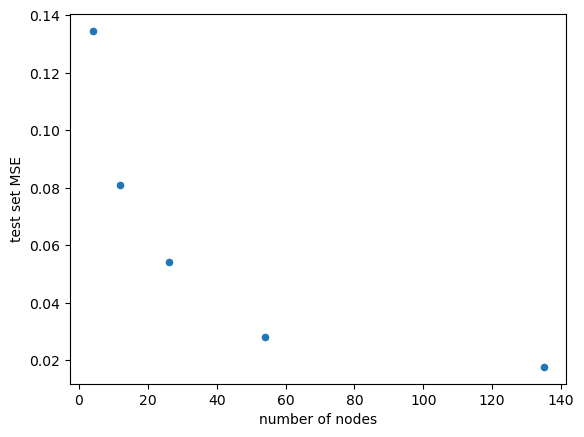

In [379]:
#find total number of nodes

def totalNodes(node):
    if node is None:
        return 0 ;
    else :
        left_depth = maxDepth(node.l)
        right_depth = maxDepth(node.r)
 
        return left_depth + right_depth + 1

data = {'Dataset': ["D32", "D128", "D512", "D2048", "D8192"],
        'nodes': [totalNodes(rootD32), totalNodes(rootD128), totalNodes(rootD512), totalNodes(rootD2048), 
                  totalNodes(rootD8192)],
       'error': [error_D32, error_D128, error_D512, error_D2048, error_D8192]}
summary = pd.DataFrame(data)
print(summary)
summary.to_latex(index=True)
summary.plot.scatter(x='nodes', y = 'error')
plt.xlabel("number of nodes")
plt.ylabel("test set MSE")
plt.savefig("./HW/HW2_learning_curve_q2")
#summary.to_csv('./HW/q2_summary.csv')


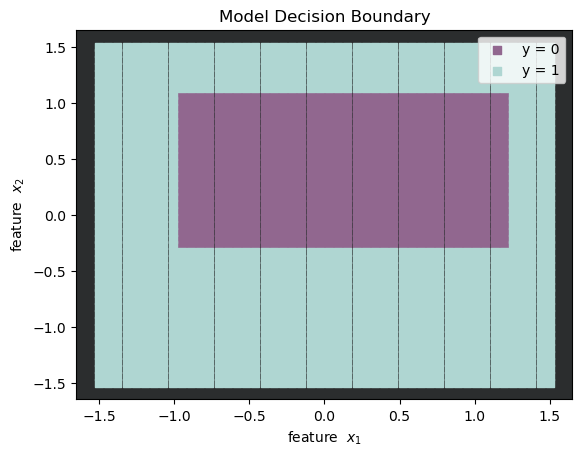

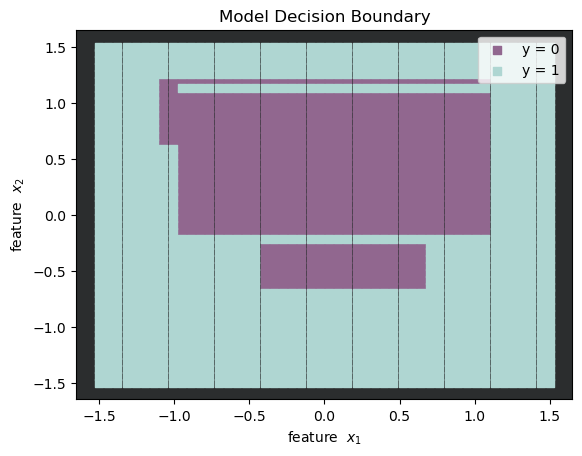

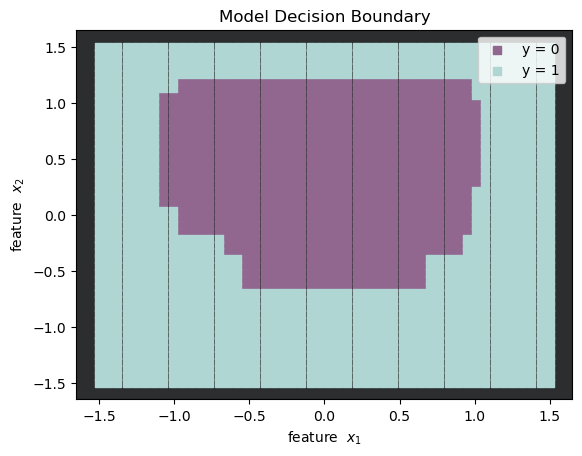

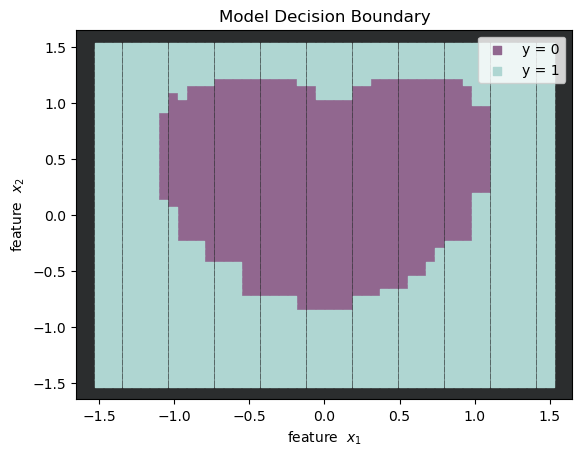

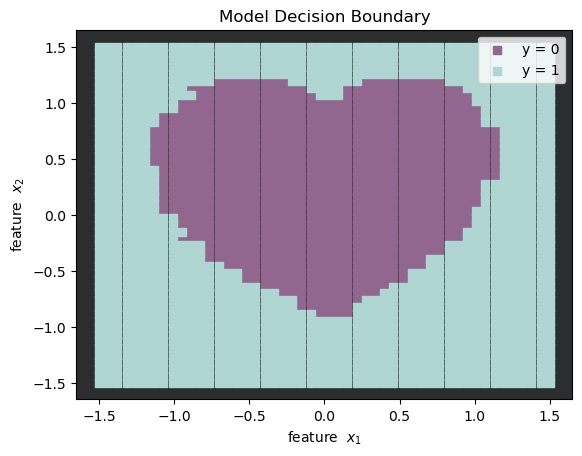

In [382]:
draw_decision_boundary(tree_prediction,rootD32, grid_min=-1.5, grid_max=1.5, savefile = './HW/HW2_decision_boundary_D32.png') # generate decision boundary plot
draw_decision_boundary(tree_prediction,rootD128, grid_min=-1.5, grid_max=1.5, savefile = './HW/HW2_decision_boundary_D128.png') # generate decision boundary plot
draw_decision_boundary(tree_prediction,rootD512, grid_min=-1.5, grid_max=1.5, savefile = './HW/HW2_decision_boundary_D512.png') # generate decision boundary plot
draw_decision_boundary(tree_prediction,rootD2048, grid_min=-1.5, grid_max=1.5, savefile = './HW/HW2_decision_boundary_D2048.png') # generate decision boundary plot
draw_decision_boundary(tree_prediction,rootD8192, grid_min=-1.5, grid_max=1.5, savefile = './HW/HW2_decision_boundary_8192.png') # generate decision boundary plot


if (x2) >= [-0.854388])

 if (x2) >= [1.126522]) return 1

 else

  if (x1) >= [1.156241]) return 1

  else

   if (x1) >= [-1.053368])

    if (x2) >= [-0.38788])

     if (x1) >= [-0.96122]) return 0

     else

      if (x2) >= 0.471272) return 0

      else return 1

    else

     if (x1) >= [-0.303347])

      if (x1) >= [0.735163]) return 1

      else return 0

     else return 1

   else return 1

else return 1



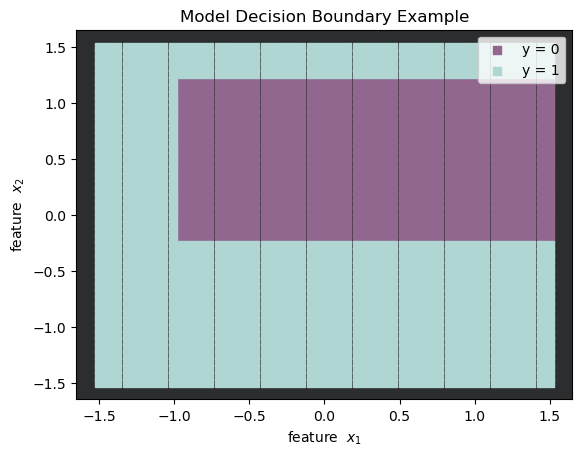

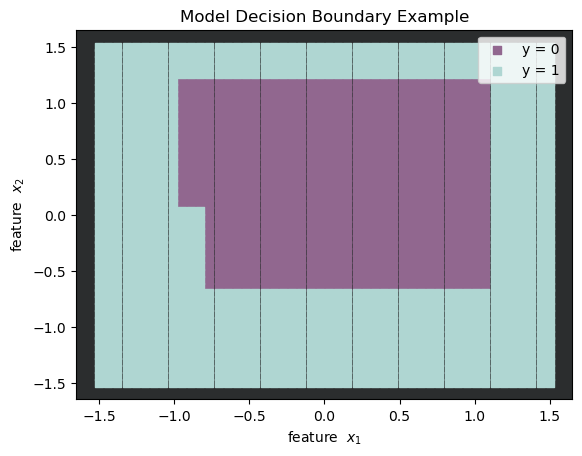

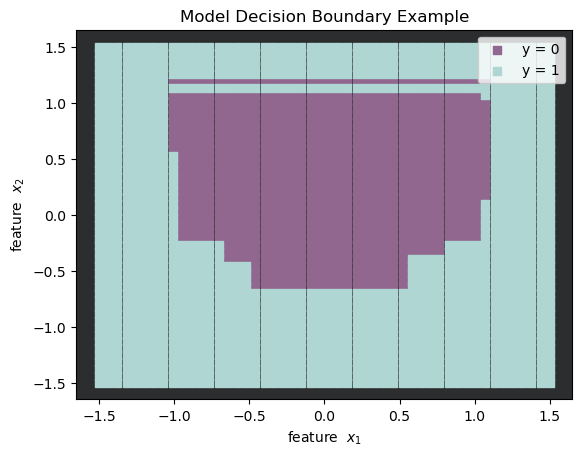

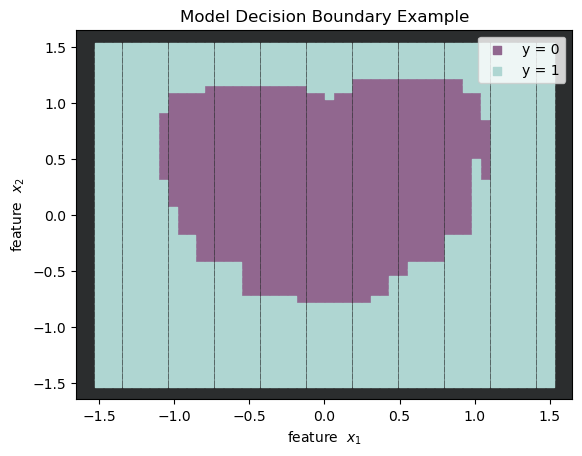

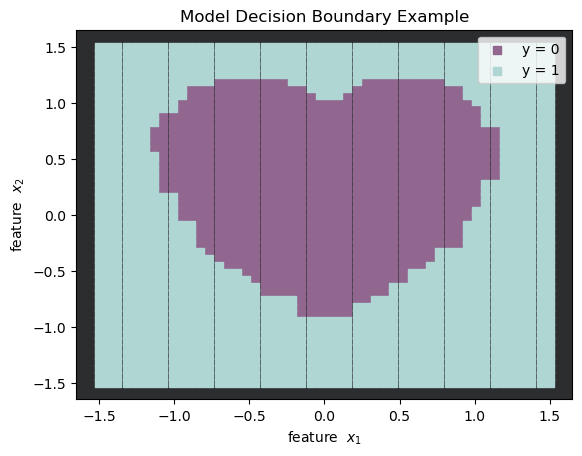

[1. 1. 0. ... 0. 0. 1.]
\begin{tabular}{llrr}
 & Dataset & number_of_nodes & error \\
0 & D32 & 9 & 0.109574 \\
1 & D128 & 23 & 0.065302 \\
2 & D512 & 53 & 0.058661 \\
3 & D2048 & 105 & 0.030437 \\
4 & D8192 & 243 & 0.016602 \\
\end{tabular}



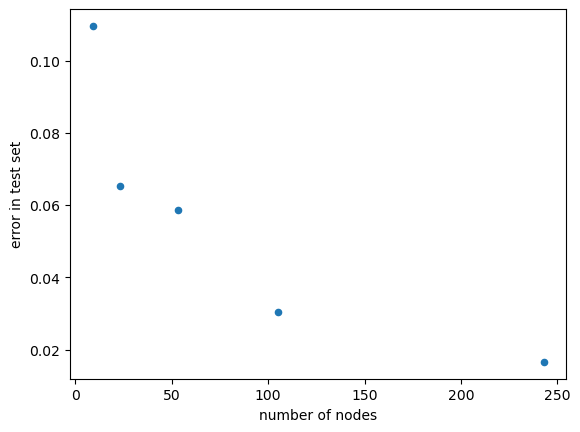

In [393]:
#Part 3 - Use sklearn

from sklearn import tree

def predict_d(dataset):
    X, y = dataset[:,[0,1]], dataset[:,-1]
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, y)
    return clf.predict(Dbig_test[:,[0,1]]), clf.tree_.node_count

def calculate_error_and_size(predictions, actual_outcomes):
    
    return (1-(np.sum(predictions==actual_outcomes)/len(predictions)))
    
X, y = D32[:,[0,1]], D32[:,-1]

D32_preds_sk, D32_size = predict_d(D32)[0], predict_d(D32)[1]
print(D32_preds_sk)
D32_error = calculate_error(D32_preds_sk, actual_outcomes)

D128_preds_sk, D128_size = predict_d(D128)[0], predict_d(D128)[1]
D128_error = calculate_error(D128_preds_sk, actual_outcomes)

D512_preds_sk, D512_size = predict_d(D512)[0], predict_d(D512)[1]
D512_error = calculate_error(D512_preds_sk, actual_outcomes)


D2048_preds_sk, D2048_size = predict_d(D2048)[0], predict_d(D2048)[1]
D2048_error = calculate_error(D2048_preds_sk, actual_outcomes)


D8192_preds_sk, D8192_size = predict_d(D8192)[0], predict_d(D8192)[1]
D8192_error = calculate_error(D8192_preds_sk, actual_outcomes)

data_summary = {'Dataset': ["D32", "D128", "D512", "D2048", "D8192"],
        'number_of_nodes': [D32_size, D128_size, D512_size, D2048_size, 
                  D8192_size],
       'error': [D32_error, D128_error, D512_error, D2048_error, D8192_error]}
summary = pd.DataFrame(data_summary)
#print(summary)
summary.plot.scatter(x = 'number_of_nodes', y = 'error')
plt.xlabel("number of nodes")
plt.ylabel("error in test set")
plt.savefig("./HW/HW2_sklearn_learning_curve.png")
print(summary.style.to_latex())
#summary.to_csv('./HW/HW2_sklearn_q2_summary.csv')

In [235]:
np.random.uniform(0,1,100)

array([0.24053978, 0.11814971, 0.93550466, 0.94144351, 0.51992241,
       0.82522855, 0.99001109, 0.68948083, 0.88785099, 0.69464523,
       0.6260986 , 0.91644547, 0.8272473 , 0.19620127, 0.81622522,
       0.73999506, 0.65641263, 0.90810706, 0.1786958 , 0.02056341,
       0.7187464 , 0.70987158, 0.46140815, 0.48518571, 0.42239008,
       0.11279975, 0.97798057, 0.76801918, 0.39012791, 0.60889198,
       0.6704787 , 0.53699712, 0.62599674, 0.23945609, 0.561558  ,
       0.95354084, 0.82603355, 0.18859103, 0.50797015, 0.08480799,
       0.9686093 , 0.54275652, 0.84503544, 0.3033532 , 0.86621369,
       0.19467137, 0.40551029, 0.19271229, 0.06192313, 0.5701312 ,
       0.59636094, 0.25466765, 0.31173867, 0.08268071, 0.28751954,
       0.91078995, 0.8835648 , 0.02241233, 0.35711597, 0.36076161,
       0.79913793, 0.08782832, 0.00443905, 0.2836526 , 0.42350168,
       0.43727828, 0.72437783, 0.80484691, 0.04541547, 0.41921957,
       0.15083752, 0.94653957, 0.6186107 , 0.70945621, 0.23335

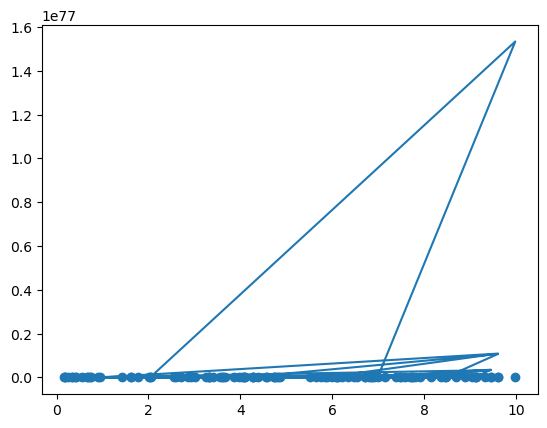

506.182971928004
507.1039811269787
[0.         0.0319422  0.0638844  0.0958266  0.12776879 0.15971099
 0.19165319 0.22359539 0.25553759 0.28747979 0.31942199 0.35136418
 0.38330638 0.41524858 0.44719078 0.47913298 0.51107518 0.54301738
 0.57495957 0.60690177 0.63884397 0.67078617 0.70272837 0.73467057
 0.76661277 0.79855496 0.83049716 0.86243936 0.89438156 0.92632376
 0.95826596 0.99020816 1.02215035 1.05409255 1.08603475 1.11797695
 1.14991915 1.18186135 1.21380355 1.24574574 1.27768794 1.30963014
 1.34157234 1.37351454 1.40545674 1.43739894 1.46934114 1.50128333
 1.53322553 1.56516773 1.59710993 1.62905213 1.66099433 1.69293653
 1.72487872 1.75682092 1.78876312 1.82070532 1.85264752 1.88458972
 1.91653192 1.94847411 1.98041631 2.01235851 2.04430071 2.07624291
 2.10818511 2.14012731 2.1720695  2.2040117  2.2359539  2.2678961
 2.2998383  2.3317805  2.3637227  2.39566489 2.42760709 2.45954929
 2.49149149 2.52343369 2.55537589 2.58731809 2.61926028 2.65120248
 2.68314468 2.71508688 2.747

In [436]:
#Part 4
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import lagrange
from sklearn.metrics import mean_squared_error
import math
import random

import warnings
warnings.filterwarnings("ignore")
n = 100
random.seed(10)
x = np.random.uniform(0, 10, n)
y = np.sin(x)
poly = lagrange(x, y)


plt.scatter(x = x, y = y)
plt.plot(x, Polynomial(poly.coef[::-1])(x), label='Polynomial')
plt.show()
predicted_train = Polynomial(poly.coef[::-1])(x)
error_train = mean_squared_error(y, predicted_train)

random.seed(10)
x_new = np.random.uniform(0, 10, n)
y_new = np.sin(x_new)
predicted_test = Polynomial(poly.coef[::-1])(x_new)
error_test = mean_squared_error(y_new, predicted_test)
print(np.log2(error_train))
print(np.log2(error_test))

#add error to training set to see if it improves MSE on test set
range_of_sd = np.linspace(0, math.sqrt(10), 100)
print(range_of_sd)
#dict = {'Variance', 'error_train', 'error_test'}
df = pd.DataFrame()
for sd in range_of_sd:
    random.seed(10)
    x = np.random.uniform(0, 10, n)
    random.seed(10)
    error = np.random.normal(0, sd, n)
    x_with_error = x+error
    y_with_error = np.sin(x+error)
    poly = lagrange(x_with_error, y_with_error)
    predicted_train = Polynomial(poly.coef[::-1])(x_with_error)
    error_train = mean_squared_error(y_with_error, predicted_train)
    predicted_test = Polynomial(poly.coef[::-1])(x_new)
    error_test = mean_squared_error(y_new, predicted_test)
    df = df.append({'SD': sd, 'error_train': error_train, 'error_test': error_test}, ignore_index = True)
    #df.loc[len(df)] = [variance, error_train, error_test]



error in training set is462.7508132130018
error in testing set is397.69367395787555


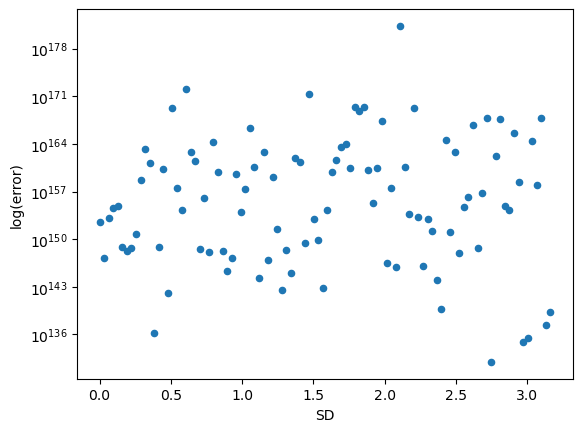

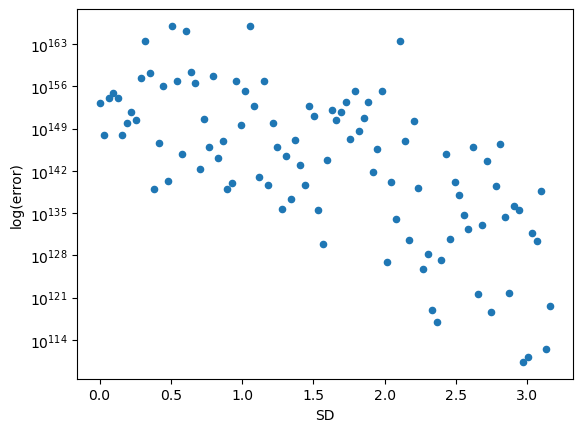

In [439]:
df.plot.scatter(x = 'SD', y = 'error_train')
plt.yscale("log")
plt.ylabel("log(error)")
plt.savefig('HW/HW2_lagrange_trainset_error.png')

df.plot.scatter(x = 'SD', y = 'error_test')
plt.yscale("log")
plt.ylabel("log(error)")
plt.savefig('HW/HW2_lagrange_testset_error.png')

log_train_error = np.log2(error_train)
log_test_error = np.log2(error_test)
print("error in training set is"+str(log_train_error))
print("error in testing set is"+str(log_test_error))